# Speed Up Transformers

## Import Libraries

In [34]:
import torch
from datasets import load_dataset, Dataset
from torch.utils.data import random_split
from config_file import get_config, get_weights_file_path
from train import get_or_build_tokenizer
from tqdm import tqdm
import numpy as np
import random
import matplotlib.pyplot as plt

## Load dataset

In [2]:
ds_raw = load_dataset('opus_books', "en-it", split = 'train')

In [3]:
config = get_config()

In [4]:
src_lang = config["lang_src"]
tgt_lang = config["lang_tgt"]
seq_len = config["seq_len"]

In [5]:
tokenizer_src = get_or_build_tokenizer(config, ds_raw, src_lang)
tokenizer_tgt = get_or_build_tokenizer(config, ds_raw, tgt_lang)

In [6]:
src_ids_list = []
tgt_ids_list = []

max_len_src = 0
max_len_tgt = 0

for item in ds_raw:
    src_ids = tokenizer_src.encode(item['translation'][src_lang]).ids
    tgt_ids = tokenizer_tgt.encode(item['translation'][tgt_lang]).ids
    src_ids_list.append(src_ids)
    tgt_ids_list.append(tgt_ids)
    max_len_src = max(max_len_src, len(src_ids))
    max_len_tgt = max(max_len_tgt, len(tgt_ids))

print(f"Max length of the source sentence : {max_len_src}")
print(f"Max length of the source target : {max_len_tgt}")

Max length of the source sentence : 309
Max length of the source target : 274


## Plot histogram of token length

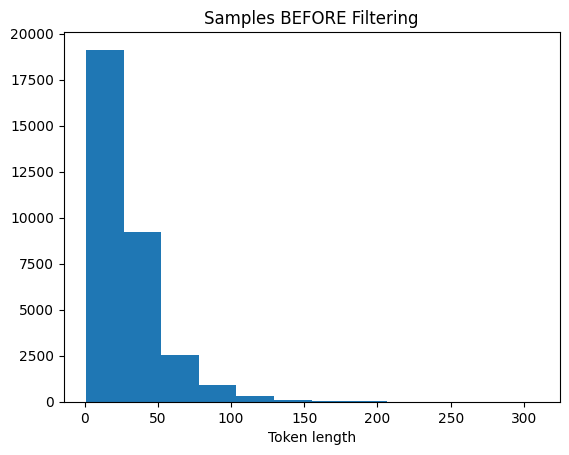

In [7]:
token_lenghts = [len(x) for x in src_ids_list]
bins = (max(token_lenghts) - min(token_lenghts))//25
plt.hist(token_lenghts, bins=bins)
plt.xlabel('Token length')
plt.title('Samples BEFORE Filtering')
plt.show()

In [8]:
new_lenth = 100
data_percentage = (np.array(token_lenghts) > 100).sum() / len(token_lenghts) * 100
print(f'Only {data_percentage:.2f}% of sentances have more than {new_lenth} tokens')

Only 1.95% of sentances have more than 100 tokens


## Check ratio of number of words in english and italian sentances

In [9]:
ds_dict = ds_raw.to_dict()

In [10]:
index = 0
ratio_list = []
while index < len(src_ids_list):
    src_token_count = len(src_ids_list[index])
    tgt_token_count = len(tgt_ids_list[index])
    if (src_token_count>100 or tgt_token_count>100):
        ratio_list.append(src_token_count/tgt_token_count)
    index += 1

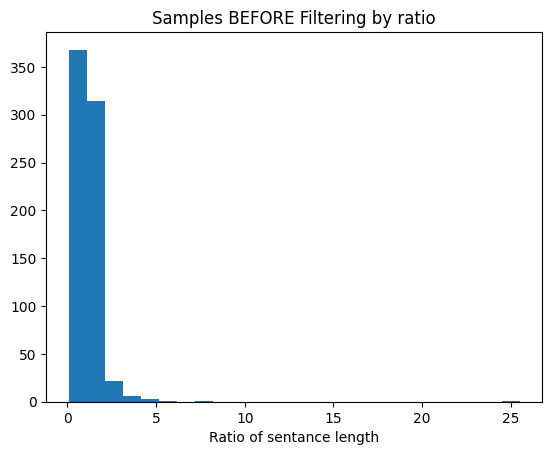

In [11]:
bins = int((max(ratio_list) - min(ratio_list))//1)
plt.hist(ratio_list, bins=bins)
plt.xlabel('Ratio of sentance length')
plt.title('Samples BEFORE Filtering by ratio')
plt.show()

In [12]:
index = 0
while index < len(src_ids_list):
    src_token_count = len(src_ids_list[index])
    tgt_token_count = len(tgt_ids_list[index])
    if (src_token_count>100 or tgt_token_count>100) and (src_token_count/tgt_token_count > 2 or tgt_token_count/src_token_count > 2):
        del src_ids_list[index]
        del tgt_ids_list[index]
        del ds_dict['id'][index]
        del ds_dict['translation'][index]
        index -= 1
    index += 1

ds_raw = Dataset.from_dict(ds_dict, features=ds_raw.features)

In [13]:
index = 0
ratio_list = []
while index < len(ds_dict['id']):
    en_word_count = len(ds_dict['translation'][index]['en'].split(' '))
    it_word_count = len(ds_dict['translation'][index]['it'].split(' '))
    if (en_word_count>100 or it_word_count>100):
        ratio_list.append(en_word_count/it_word_count)
    index += 1

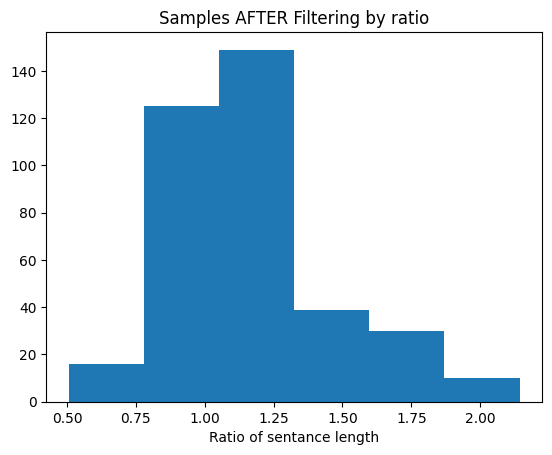

In [14]:
bins = int((max(ratio_list) - min(ratio_list))//0.25)
plt.hist(ratio_list, bins=bins)
plt.xlabel('Ratio of sentance length')
plt.title('Samples AFTER Filtering by ratio')
plt.show()

## Plot histogram of length

Let’s look at the lengths of the samples in their original data. The histogram plot below simply confirms that the samples with length 100 are very less.

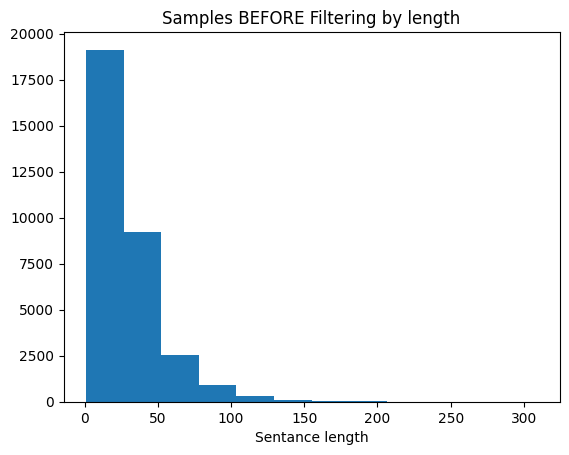

In [15]:
token_lenghts = [len(x) for x in src_ids_list]
bins = (max(token_lenghts) - min(token_lenghts))//25
plt.hist(token_lenghts, bins=bins)
plt.xlabel('Sentance length')
plt.title('Samples BEFORE Filtering by length')
plt.show()

In [16]:
new_lenth = 100
data_percentage = (np.array(token_lenghts) > 100).sum() / len(token_lenghts) * 100
print(f'Only {data_percentage:.2f}% of sentances have more than {new_lenth} tokens')

Only 1.82% of sentances have more than 100 tokens


In [17]:
ds_dict = ds_raw.to_dict()

In [18]:
new_id = int(ds_dict['id'][-1])
index = 0
while index < len(src_ids_list):
    id = ds_dict['id'][index]
    src_token_count = len(src_ids_list[index])
    tgt_token_count = len(tgt_ids_list[index])
    if src_token_count > new_lenth or tgt_token_count > new_lenth:
        num_division = 2
        new_src_token_count = src_token_count//num_division
        new_tgt_token_count = tgt_token_count//num_division
        while new_src_token_count > new_lenth or new_tgt_token_count > new_lenth:
            num_division += 1
            new_src_token_count = src_token_count//num_division
            new_tgt_token_count = tgt_token_count//num_division
        token_count_src = 0
        token_count_tgt = 0
        for _ in range(num_division):
            sentance_src = src_ids_list[index][token_count_src : token_count_src + new_src_token_count]
            sentance_tgt = tgt_ids_list[index][token_count_tgt : token_count_tgt + new_tgt_token_count]
            src_ids_list.append(sentance_src)
            tgt_ids_list.append(sentance_tgt)
            ds_dict['id'].append(str(new_id))
            ds_dict['translation'].append({'en': tokenizer_src.decode(sentance_src), 'it': tokenizer_tgt.decode(sentance_tgt)})
            new_id += 1
            token_count_src += new_src_token_count
            token_count_tgt += new_tgt_token_count
        del src_ids_list[index]
        del tgt_ids_list[index]
        del ds_dict['id'][index]
        del ds_dict['translation'][index]
        index -= 1
    index += 1

ds_raw = Dataset.from_dict(ds_dict, features=ds_raw.features)

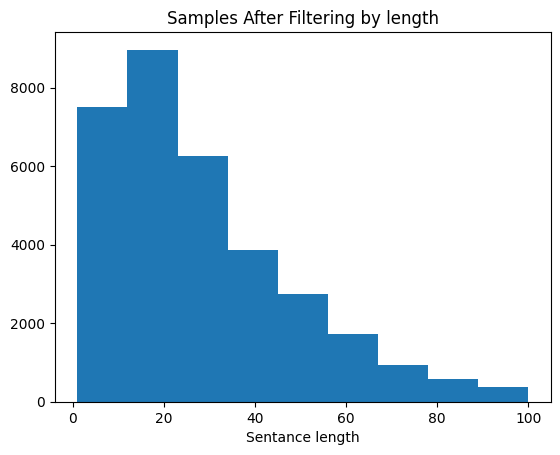

In [19]:
token_lenghts = [len(x) for x in src_ids_list]
bins = (max(token_lenghts) - min(token_lenghts))//10
plt.hist(token_lenghts, bins=bins)
plt.xlabel('Sentance length')
plt.title('Samples After Filtering by length')
plt.show()

Let’s look at the lengths of the samples in their original, unsorted order. The below plot simply confirms that the sample lengths do vary significantly, and that they are unsorted.

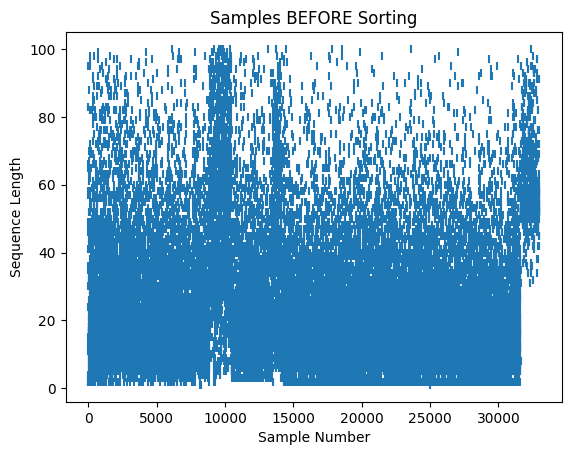

In [20]:
plt.scatter(range(0, len(token_lenghts)), token_lenghts, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

In [21]:
ds_dict = ds_raw.to_dict()

In [22]:
id, translation, src_ids_list, tgt_ids_list = zip(*[(x, y, z, w) for x, y, z, w in
                                                    sorted(zip(ds_dict['id'], ds_dict['translation'], src_ids_list, tgt_ids_list),
                                                            key=lambda x: len(x[2]))])
ds_dict['id'] = id
ds_dict['translation'] = translation
ds_raw = Dataset.from_dict(ds_dict, features=ds_raw.features)

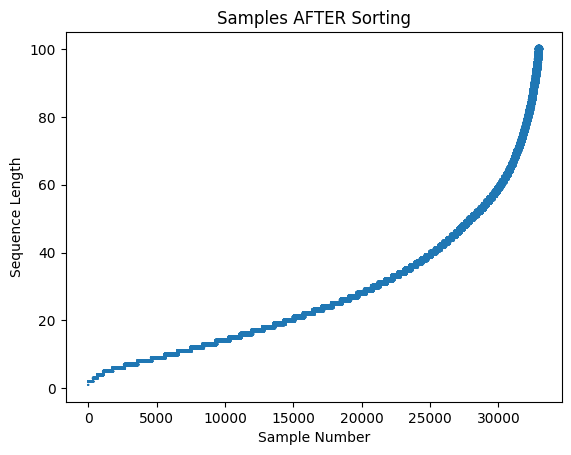

In [23]:
token_lenghts = [len(x) for x in src_ids_list]
plt.scatter(range(0, len(token_lenghts)), token_lenghts, token_lenghts, marker=".")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples AFTER Sorting')

plt.show()

## Combine inputs

In [24]:
ds_dict = ds_raw.to_dict()

In [25]:
half_lenght = len(ds_dict['id'])//2
ds_dict_half1 = {'id':ds_dict['id'][:half_lenght], 'translation':ds_dict['translation'][:half_lenght]}
ds_dict_half1['id'].reverse()
ds_dict_half1['translation'].reverse()
ds_dict_half2 = {'id':ds_dict['id'][half_lenght:], 'translation':ds_dict['translation'][half_lenght:]}
combined_sentances = [{'en': x['en'] + " " + y['en'], 'it': x['it'] + " " + y['it']}
                       for x,y in zip(ds_dict_half1['translation'], ds_dict_half2['translation'])]
ds_dict_half2['translation'] = combined_sentances
ds_raw = Dataset.from_dict(ds_dict_half2, features=ds_raw.features)

In [26]:
src_ids_list = []
tgt_ids_list = []

max_len_src = 0
max_len_tgt = 0

for item in ds_raw:
    src_ids = tokenizer_src.encode(item['translation'][src_lang]).ids
    tgt_ids = tokenizer_tgt.encode(item['translation'][tgt_lang]).ids
    src_ids_list.append(src_ids)
    tgt_ids_list.append(tgt_ids)
    max_len_src = max(max_len_src, len(src_ids))
    max_len_tgt = max(max_len_tgt, len(tgt_ids))

print(f"Max length of the source sentence : {max_len_src}")
print(f"Max length of the source target : {max_len_tgt}")

Max length of the source sentence : 102
Max length of the source target : 145


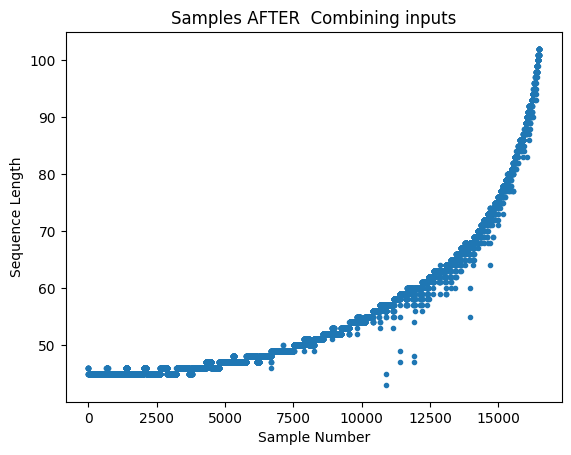

In [27]:
token_lenghts = [len(x) for x in src_ids_list]
plt.scatter(range(0, len(token_lenghts)), token_lenghts, marker=".")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples AFTER  Combining inputs')

plt.show()

## Random Batch Selection

In [28]:
ds_dict = ds_raw.to_dict()

In [29]:
batch_size = 16
id_list = []
translation_list = []

while len(ds_dict['id']) > 0:  

    to_take = min(batch_size, len(ds_dict['id']))
    select = random.randint(0, len(ds_dict['id']) - to_take)
    ids = ds_dict['id'][select:(select + to_take)]
    translations = ds_dict['translation'][select:(select + to_take)]
    id_list.extend(ids)
    translation_list.extend(translations)
    del ds_dict['id'][select:select + to_take]
    del ds_dict['translation'][select:select + to_take]

ds_dict['id'] = id_list
ds_dict['translation'] = translation_list
ds_raw = Dataset.from_dict(ds_dict, features=ds_raw.features)